# Experimenting with orthogonality and different orthonormalizations (Under construction)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from monty.serialization import loadfn
from pymatgen.io.cif import CifParser
from pymatgen.core.structure import Structure
from sklearn.linear_model import LinearRegression
from smol.cofe import ClusterSubspace, StructureWrangler, ClusterExpansion, RegressionData
from smol.moca import ClusterExpansionProcessor, CanonicalEnsemble
%matplotlib inline

# load the prim structure
lno_prim = loadfn('data/lno_prim.json')    
    
# load the fitting data
lno_entries = loadfn("data/lno_entries.json")

## Orthogonal vs Non-orthogonal basis
First lets look at how things can change when we use an orthogonal basis vs a non-orthogonal one.

In [2]:
# Create a cluster subspace with orthonormal basis functions
cs_or = ClusterSubspace.from_cutoffs(structure=lno_prim,
                                    cutoffs={2: 5, 3: 4.1},
                                    ltol=0.15, stol=0.2, angle_tol=5,
                                    supercell_size='O2-',
                                    basis='indicator',
                                    orthonormal=True)

# Now one with the standard non-orthogonal indicator basis
cs_nor = ClusterSubspace.from_cutoffs(structure=lno_prim,
                                    cutoffs={2: 5, 3: 4.1},
                                    ltol=0.15, stol=0.2, angle_tol=5,
                                    supercell_size='O2-',
                                    basis='indicator',
                                    orthonormal=False)


# Check if things are orthogonal
print(cs_or.basis_orthonormal, cs_nor.basis_orthonormal)

True False


In [3]:
# Put data in a structure Wranger for later

wrangler_or = StructureWrangler(cs_or)
for entry in lno_entries:
    wrangler_or.add_entry(entry, verbose=False)


wrangler_nor = StructureWrangler(cs_nor)
for entry in lno_entries:
    wrangler_nor.add_entry(entry, verbose=False)

### Fit a CE with the two bases

In [4]:
from sklearn.linear_model import LinearRegression

# for orthonormal basis
estimator_or = LinearRegression(fit_intercept=False)
estimator_or.fit(wrangler_or.feature_matrix,
              wrangler_or.get_property_vector('energy'))

reg_data_or = RegressionData.from_sklearn(estimator_or,
                                       wrangler_or.feature_matrix,
                                       wrangler_or.get_property_vector('energy'))
expansion_or = ClusterExpansion(cs_or,
                             coefficients=estimator_or.coef_,
                             regression_data=reg_data_or)


# for non-orthogonal basisi
estimator_nor = LinearRegression(fit_intercept=False)
estimator_nor.fit(wrangler_nor.feature_matrix,
              wrangler_nor.get_property_vector('energy'))

reg_data_nor = RegressionData.from_sklearn(estimator_nor,
                                       wrangler_nor.feature_matrix,
                                       wrangler_nor.get_property_vector('energy'))
expansion_nor = ClusterExpansion(cs_nor,
                             coefficients=estimator_nor.coef_,regression_data=reg_data_nor)

In [5]:
from sklearn.metrics import mean_squared_error, max_error

train_predictions_or = np.dot(wrangler_or.feature_matrix,
                           expansion_or.coefs)
rmse = mean_squared_error(wrangler_or.get_property_vector('energy'),
                          train_predictions_or, squared=False)
maxer = max_error(wrangler_or.get_property_vector('energy'),
                  train_predictions_or)

print('"Details of the fit for orthonormal basis"')

print(f'RMSE (orthonormal) {rmse} eV/prim')
print(f'MAX (orthonormal) {maxer} eV/prim')
print(f'Fitted dielectric constant (orthonormal) {1/expansion_or.coefs[-1]}')


train_predictions_nor = np.dot(wrangler_nor.feature_matrix,
                           expansion_nor.coefs)
rmse = mean_squared_error(wrangler_nor.get_property_vector('energy'),
                          train_predictions_nor, squared=False)
maxer = max_error(wrangler_nor.get_property_vector('energy'),
                  train_predictions_nor)

print('')
print('"Details of the fit for non-orthogonal basis"')
print(f'RMSE (non-orthogonal) {rmse} eV/prim')
print(f'MAX (non-orthogonal) {maxer} eV/prim')
print(f'Fitted dielectric constant (non-orthogonal) {1/expansion_nor.coefs[-1]}')


"Details of the fit for orthonormal basis"
RMSE (orthonormal) 0.009973122786563739 eV/prim
MAX (orthonormal) 0.019123139061385075 eV/prim
Fitted dielectric constant (orthonormal) 38.431411030417244

"Details of the fit for non-orthogonal basis"
RMSE (non-orthogonal) 0.009973122786563739 eV/prim
MAX (non-orthogonal) 0.019123139061385075 eV/prim
Fitted dielectric constant (non-orthogonal) 38.431411030417244


### Look at differences between a correlation vectors
Notice that for the standard indicator correlations will always be positive, but for an orthonormalized basis this is not always the case.

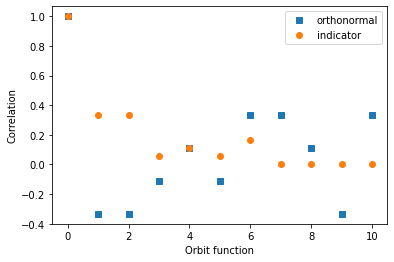

In [6]:
i = random.randint(0, len(wrangler_or.structures))
plt.plot(cs_or.corr_from_structure(wrangler_or.structures[i]), 's')

plt.plot(cs_nor.corr_from_structure(wrangler_nor.structures[i]), 'o')

plt.xlabel('Orbit function')
plt.ylabel('Correlation')
plt.legend(['orthonormal', 'indicator'])

### Compare canonical Monte Carlo runs with the different bases
Finally lets look at how MC runs differ for orthogonal vs non-orthogonal bases.

In [9]:
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation


# Create a supercell matrix
sc_matrix = np.array([[4, 0, 0],
                      [0, 2, 0],
                      [0, 0, 1]])

# Here we will just use the order disordered transformation from
# pymatgen to get an ordered version of a prim supercell.
# The structure will have the same composition set in the prim.
transformation = OrderDisorderedStructureTransformation()

supercell = expansion_or.cluster_subspace.structure.copy()
supercell.make_supercell(sc_matrix)

# this can take a bit of time....
test_struct = transformation.apply_transformation(supercell)
print(test_struct.composition)



Li+4 Ni3+4 Ni4+4 O2-16


In [10]:
from smol.moca import Sampler

# this convenience method will take care of creating the appropriate
# processor for the given cluster expansion.
ensemble_or = CanonicalEnsemble.from_cluster_expansion(expansion_or,
                                                    sc_matrix)

ensemble_nor = CanonicalEnsemble.from_cluster_expansion(expansion_nor,
                                                    sc_matrix)

# Define initial occupancy

init_occu_or = ensemble_or.processor.occupancy_from_structure(test_struct)

init_occu_nor = ensemble_nor.processor.occupancy_from_structure(test_struct)



# This will take care of setting the defaults
# for the supplied canonical ensemble
sampler_or = Sampler.from_ensemble(ensemble_or,
                                temperature=2000)

sampler_nor = Sampler.from_ensemble(ensemble_nor,
                                temperature=2000)


sampler_or.run(1000000,
            initial_occupancies=init_occu_or,
            thin_by=200, # thin_by will save every 100th sample only
            progress=True) # progress will show progress bar



sampler_nor.run(1000000,
            initial_occupancies=init_occu_nor,
            thin_by=200, # thin_by will save every 100th sample only
            progress=True) # progress will show progress bar


Sampling 1 chain(s) from a cell with 32 sites...: 100%|██████████| 1000000/1000000 [04:08<00:00, 4020.34it/s]


In [11]:
# Samples are saved in a sample container
samples_or = sampler_or.samples

print('"Details of the MC run for orthonormal basis"')
print(f'Fraction of successful steps (efficiency) {sampler_or.efficiency()}')
print(f'The last step energy is {samples_or.get_energies()[-1]} eV')
print(f'The minimum energy in trajectory is {samples_or.get_minimum_energy()} eV')

# You can get the minimum energy structure and current structure
# by using the ensemble processor
curr_s_or = ensemble_or.processor.structure_from_occupancy(samples_or.get_occupancies()[-1])
min_s_or = ensemble_or.processor.structure_from_occupancy(samples_or.get_minimum_energy_occupancy())

samples_nor = sampler_nor.samples
print('')
print('"Details of the MC run for non orthogonal basis"')
print(f'Fraction of successful steps (efficiency)(non-orthogonal) {sampler_nor.efficiency()}')
print(f'The last step energy (for non-orthogonal) is {samples_nor.get_energies()[-1]} eV')
print(f'The minimum energy (for non-orthogonal) in trajectory is {samples_nor.get_minimum_energy()} eV')

# You can get the minimum energy structure and current structure
# by using the ensemble processor
curr_s_nor = ensemble_nor.processor.structure_from_occupancy(samples_nor.get_occupancies()[-1])
min_s_nor = ensemble_nor.processor.structure_from_occupancy(samples_nor.get_minimum_energy_occupancy())


"Details of the MC run for orthonormal basis"
Fraction of successful steps (efficiency) 0.000103
The last step energy is -254.68885736147269 eV
The minimum energy in trajectory is -254.88589239675727 eV

"Details of the MC run for non orthogonal basis"
Fraction of successful steps (efficiency)(non-orthogonal) 0.00291
The last step energy (for non-orthogonal) is -276.1373985714158 eV
The minimum energy (for non-orthogonal) in trajectory is -276.5632651124954 eV


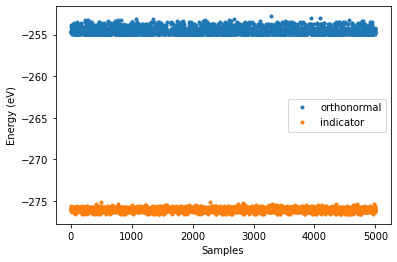

In [12]:
energies_or = samples_or.get_energies()
energies_nor = samples_nor.get_energies()

plt.plot(energies_or, '.')
plt.plot(energies_nor, '.')
plt.xlabel('Samples')
plt.ylabel('Energy (eV)')
plt.legend(['orthonormal', 'indicator'])

## Constructing a Cluster Subspace orthonormalized with respect to a concentration measure
This orthonormalized the basis functions with respect to the concentrations given in the prim structure. Note this does not give you a "concentration dependent" ECI's. Only ECI's centered about the given concentration.

In [13]:
# The prim is set to sites concentrations (Li+: 0.5, Vacancy: 0.5), (Ni+: 0.5, Ni: 40.5).
# You can see this from printing it.
# This is equivalent to a uniform concentration. So it is not different then standard orthonormalization.
print(lno_prim)
cs_onc = ClusterSubspace.from_cutoffs(structure=lno_prim,
                                    cutoffs={2: 5, 3: 4.1},
                                    ltol=0.15, stol=0.2, angle_tol=5,
                                    supercell_size='O2-',
                                    basis='sinusoid',
                                    orthonormal=True,
                                    use_concentration=True) # this will use the concentrations in the prim structure
                                                            # to create the "concentration-centered" basis

# Create another one without using concentration
cs_on = ClusterSubspace.from_cutoffs(structure=lno_prim,
                                    cutoffs={2: 5, 3: 4.1},
                                    ltol=0.15, stol=0.2, angle_tol=5,
                                    supercell_size='O2-',
                                    basis='sinusoid') # Note sinusoid is by construction already orthogonal.
# We can check orthogonality
print(cs_onc.basis_orthonormal, cs_on.basis_orthogonal)

Full Formula (Li0.5 Ni1 O2)
Reduced Formula: Li0.5Ni1O2
abc   :   2.969848   2.969848   5.143928
angles:  73.221350  73.221347  60.000002
Sites (4)
  #  SP                         a     b     c
---  ----------------------  ----  ----  ----
  0  Li+:0.500               0     0     0
  1  Ni3+:0.500, Ni4+:0.500  0.5   0.5   0.5
  2  O2-                     0.75  0.75  0.75
  3  O2-                     0.25  0.25  0.25
True True


In [15]:
wrangler_onc = StructureWrangler(cs_onc)
for entry in lno_entries:
    wrangler_onc.add_entry(entry, verbose=False)
    
wrangler_on = StructureWrangler(cs_on)
for entry in lno_entries:
    wrangler_on.add_entry(entry, verbose=False)

In [16]:
print(cs_onc.corr_from_structure(wrangler_onc.structures[0]))
print(cs_on.corr_from_structure(wrangler_on.structures[0]))

[ 1.         -0.66666667 -0.66666667  0.44444444  0.55555556  0.55555556
  0.55555556 -0.44444444 -0.44444444 -0.66666667 -0.66666667]
[1.         0.66666667 0.66666667 0.44444444 0.55555556 0.55555556
 0.55555556 0.44444444 0.44444444 0.66666667 0.66666667]
